<a href="https://colab.research.google.com/github/BlackBoyZeus/computervision-S-/blob/main/Train_a_Package_Detector_with_Two_Labeled_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train a Package Detector with Two Labeled Images

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)]()
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)


Roboflow makes it easy to create computer vision datasets and train machine learning models from them. Roboflow's Autodistill library is one tool for this - it lets you automatically label your data with pre-trained computer vision models.

SegGPT is designed to draw segmentation masks “in context”: by looking at the labels of a few “context” images, SegGPT can predict the labels of unseen images. autodistill_seggpt is a package that provides a wrapper for the SegGPT transformer model. We will be using this package to label images for a package detection segmentation model.

In this notebook, we will download a few labeled images from a Roboflow project, provide them to our `autodistill_seggpt` package, and use `autodistill_seggpt` to label the rest of the images in the project. Finally, we will train a deploy-ready computer vision model on our new dataset.

**Let's begin!**

In [1]:
# Install dependencies
!pip install -qq roboflow autodistill_seggpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━

## Creating a dataset

We begin with a box-and-parcel dataset of 225 images. This dataset contains pictures of boxes and parcels moving down a conveyor belt.

The `autodistill_seggpt` package learns to label images from examples - as such, we need to provide it with a partially-labeled dataset on Roboflow.

If you are already making a dataset on Roboflow, you can paste the link into the `roboflow_url` field below.

Otherwise, you can create a new dataset on Roboflow:

1. Create a project on Roboflow. Select "Instance Segmentation".

2. Upload a bunch of images (we recommend more than 20).

3. Then label 1 or 2 images, and add them to your dataset.

4. Paste your dataset link into the `roboflow_url` field below.

After following these steps, my dataset looks like so:

<img width="944" alt="Roboflow Annotate window - 223 Unannotated images, 2 Annotated images" src="https://user-images.githubusercontent.com/26335275/269968763-cff8422d-03fe-4ad4-b7b6-c1dc118f0bb6.png">

In [2]:
import roboflow
roboflow.login()
api_key = roboflow.load_roboflow_api_key()

#@title Download labelled images from the Roboflow API
roboflow_url = "https://universe.roboflow.com/ultrabrain/crowd-her89" #@param {type:"string"}
image_limit = 2000 #@param {type: "number"}

import re
(workspace_id, project_id) = (m.group(1), m.group(2)) if (m := re.match(r"https:\/\/(?:app|universe|api)\.roboflow\.com\/([^/]+)\/([^/]+)", roboflow_url)) else (None, None)


rf = roboflow.Roboflow()
workspace = rf.workspace(workspace_id)
project = rf.project(project_id)

import os
import shutil
import requests

def download_image(url,filename):
  img_data = requests.get(url).content
  with open(filename, 'wb') as handler:
      handler.write(img_data)

def replace_dir(dir):
  if os.path.exists(dir):
    shutil.rmtree(dir)
  os.mkdir(dir)

def download_unlabelled_images(project,output_dir="unlabelled"):

  search_url = f'https://api.roboflow.com/{project.id}/search'

  print(f"Loading unlabelled images from: {search_url}")

  replace_dir(output_dir)

  offset = 0
  while True:
      response = requests.post(
          search_url,
          json={
              'limit': 250,
              'offset': offset,
              'in_dataset':False,
              'fields': ['id', 'owner']
          },
          headers={
              'Authorization': f'Bearer {api_key}'
          }
      )

      if response.status_code != 200:
          print(f"Error: {response.status_code}. {response.json().get('error', 'No additional information available.')}")
          break

      results = response.json().get('results', [])

      numResults = len(results)
      offset = offset + numResults

      if numResults == 0 or offset > image_limit:
          break

      for image in results:
          og_url = f"https://storage.googleapis.com/roboflow-platform-sources/{image['owner']}/{image['id']}/original.jpg"
          download_image(og_url,f"{output_dir}/{image['id']}.jpg")

import os
import json
import shutil
from PIL import Image

def load_all_datasets(coco_dir:str):
  curr_dataset = None
  for split in ["train","test","valid"]:
    if os.path.exists(f"{labelled_dir}/{split}"):
      next_dataset = sv.DetectionDataset.from_coco(
          images_directory_path=f"{labelled_dir}/{split}",
          annotations_path=f"{labelled_dir}/{split}/_annotations.coco.json",
          force_masks=True
      )
      if curr_dataset is None: curr_dataset = next_dataset
      else:
        curr_dataset.images = {**curr_dataset.images,**next_dataset.images}
        curr_dataset.annotations = {**curr_dataset.annotations,**next_dataset.annotations}

  return curr_dataset

def download_labelled_images(project,output_dir="labelled"):

    replace_dir(output_dir)

    version_num = project.generate_version(settings={
      "augmentation": {
        "bbblur": False,
        "bbbrightness": False,
        "bbcrop": False,
        "bbexposure": False,
        "bbflip": False,
        "bbnoise": False,
        "bbninety": False,
        "bbrotate": False,
        "bbshear": False,
        "blur": False,
        "brightness": False,
        "crop": False,
        "cutout": False,
        "exposure": False,
        "flip": False,
        "hue": False,
        "image": False,
        "mosaic": False,
        "ninety": False,
        "noise": False,
        "rgrayscale": False,
        "rotate": False,
        "saturation": False,
        "shear": False
      },
      "preprocessing": {
        "auto-orient": False,
        "contrast": False,
        "filter-null": False,
        "grayscale": False,
        "isolate": False,
        "remap": False,
        "resize": False,
        "static-crop": False,
        "tile": False
      }
    })


    version = project.version(version_num)
    version.export("coco-segmentation")
    version.download(model_format="coco-segmentation", location=output_dir)

    return load_all_datasets(output_dir)


visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...


In [3]:
import supervision as sv

labelled_dir = "labelled"
sv_dataset = download_labelled_images(project,labelled_dir)


Dataset version generation initialized for new version 10.
Generating version still in progress. Progress: 0.0%
Exporting format coco-segmentation in progress : 50.0%
Version export complete for coco-segmentation format

Version export complete for coco-segmentation format



Extracting Dataset Version Zip to labelled in coco-segmentation:: 100%|██████████| 59/59 [00:00<00:00, 4309.49it/s]


### Select a handful of labelled images

You can improve the accuracy of `autodistill_seggpt` by giving it more labelled images. However, `autodistill_seggpt` works fastest with only a few (1-5) labelled images.

In [4]:
from autodistill_seggpt.dataset_utils import shrink_dataset_to_size

max_images = 48

sv_dataset = shrink_dataset_to_size(sv_dataset,max_images)

Installing SegGPT...


## Visualize your labelled images

These are the examples that `autodistill_seggpt` is going to learn from.

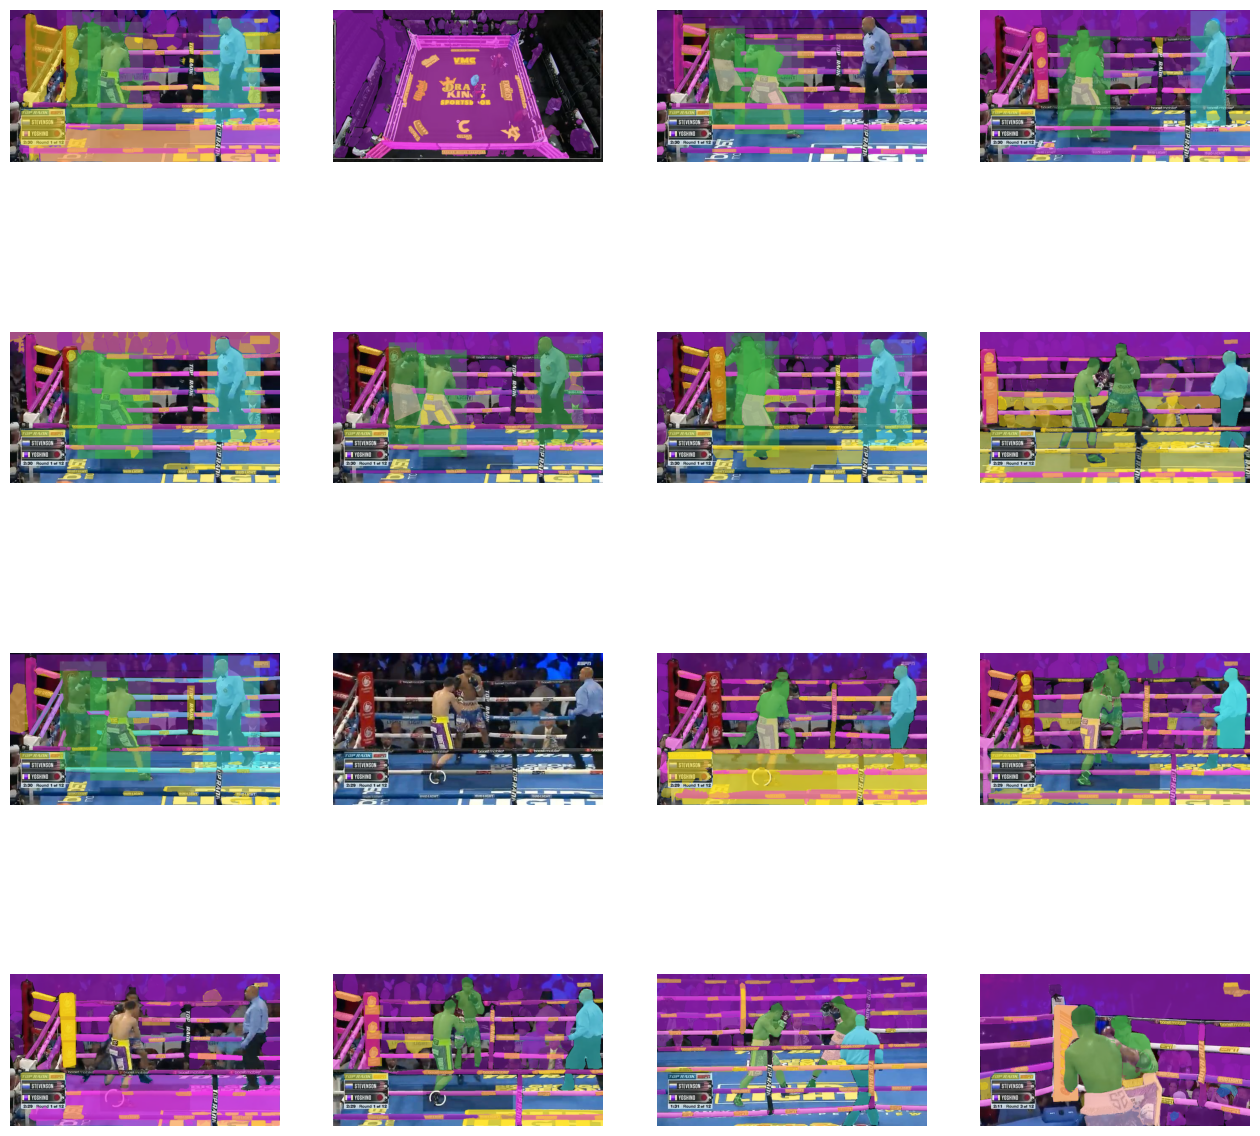

In [5]:
from autodistill_seggpt.dataset_utils import viz_dataset

viz_dataset(sv_dataset)

## Create a SegGPT base model in Autodistill

In Autodistill, a "base model" is a pre-trained computer vision model that can label your data for you. SegGPT is one such base model.

Each base model uses an "ontology" - a description of what classes are in your dataset and which objects should be labeled.

Because SegGPT learns from your data labels, your labeled dataset is the ontology. We call this a "few shot ontology".

In [6]:
from autodistill_seggpt import SegGPT,FewShotOntology

base_model = SegGPT(
    ontology=FewShotOntology(sv_dataset),
    refine_detections=True
)

### Download your unlabelled images

You should ensure your Roboflow project has plenty of unlabelled images for `autodistill_seggpt` to label.

In my "Parcels vs. boxes" project, I have 223 unlabelled images.



In [7]:
unlabelled_dir = "unlabelled"
download_unlabelled_images(project,unlabelled_dir)

Loading unlabelled images from: https://api.roboflow.com/ultrabrain/crowd-her89/search


## Test SegGPT on a few images

Now that we have a base model and some images to label, let's see what labels it makes!

Here, we take a small subset of our unlabelled images, and show how well `autodistill_seggpt` labels them.

In [8]:
demo_dir = "demo"
num_demo_imgs = 10

import random
import os

!rm -rf $demo_dir ${demo_dir}_labeled
!mkdir -p $demo_dir

demo_files = random.sample(os.listdir(unlabelled_dir),num_demo_imgs)
for file in demo_files:
  !cp $unlabelled_dir/$file $demo_dir/$file

In [10]:
base_model.label(demo_dir, extension=".jpg")

demo_dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{demo_dir}_labeled/train/images",
    annotations_directory_path=f"{demo_dir}_labeled/train/labels",
    data_yaml_path=f"{demo_dir}_labeled/data.yaml",
    force_masks=True
)


print("\n\nAutodistill's labelled images:\n\n")
viz_dataset(demo_dataset)

Labeling demo/WwEU9ZgN3doHNzyta7zh.jpg:   0%|          | 0/10 [00:08<?, ?it/s]


OutOfMemoryError: ignored

## (Optional) Improve SegGPT’s Accuracy

If you are happy with `autodistill_seggpt`'s labels, continue on!

If `autodistill_seggpt`'s labels are inaccurate, consider labeling 2 or 3 more images.

SegGPT learns from examples, so if it is performing poorly for one class or in one environment (e.g. parcels in the top-left corner of the screen), you should label another image with a parcel in the top-left corner of the screen.

## Label all your images

In [ ]:
!rm -rf ${unlabelled_dir}_labeled
base_model.label(unlabelled_dir, extension=".jpg")

pred_dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{unlabelled_dir}_labeled/train/images",
    annotations_directory_path=f"{unlabelled_dir}_labeled/train/labels",
    data_yaml_path=f"{unlabelled_dir}_labeled/data.yaml",
    force_masks=True
)


print("\n\nAutodistill's labelled images:\n\n")
viz_dataset(pred_dataset)

## Upload your labeled images

We will use the Roboflow API (plus a bit of parallelization) to upload our newly labelled images to our dataset.

Note: you should only upload your images if SegGPT's labels are high-quality and accurate.

In [ ]:
input("Press Enter to upload your images:")

In [ ]:
import glob
import concurrent.futures
from tqdm import tqdm
import sys

upload_split_balance = {
    "train":0.8,
    "valid":0.1,
    "test":0.1,
}

import random
def get_random_split():
    curr_seed = random.random()
    for split_candidate in ["train","valid","test"]:
        curr_seed -= upload_split_balance[split_candidate]
        if curr_seed < 0:
            return split_candidate


def upload_file(img_file: str):
    project.upload(
        image_path=img_file, annotation_path=label_file, split=get_random_split()
    )

num_workers=10
def parallel_upload(file_list):
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=num_workers
    ) as executor:
        list(
            tqdm(
                executor.map(upload_file, file_list),
                total=len(file_list),
                file=sys.stdout,
            )
        )

for split in ["train","valid","test"]:
  print(f"Uploading {split} dataset...")
  pred_dataset = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{unlabelled_dir}_labeled/{split}/images",
      annotations_directory_path=f"{unlabelled_dir}_labeled/{split}/labels",
      data_yaml_path=f"{unlabelled_dir}_labeled/data.yaml",
      force_masks=True
  )
  label_file = f"{split}_annotations.coco.json"
  pred_dataset.as_coco(None,label_file)
  parallel_upload(
      glob.glob(f"{unlabelled_dir}_labeled/{split}/images/*"),
  )

print("Done!")

## Train a model on Roboflow

In [ ]:
final_version_num = project.generate_version(settings={
    "augmentation":{},
    "preprocessing":{}
})
project.version(final_version_num).train(plot_in_notebook=True)